In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano
import numpy as np
from keras.layers import Input, Dense, convolutional,Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Model
from keras.optimizers import *

%matplotlib inline






Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [53]:
# this is our input placeholder
input_img = Input(shape=(3,32,32))

x = convolutional.Convolution2D(32, 5, 5, activation='relu', border_mode='same')(input_img)##64, 28, 28
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x)##64, 14, 14
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x) ##32, 12, 12
x = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) ##32, 6, 6
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x) ##16, 4, 4
encoded = convolutional.MaxPooling2D((2, 2), border_mode='same')(x) ##16, 2, 2

#x = Flatten()(encoded) ##64
#encoded = Dense(40, activation='sigmoid')(x)

#x= Dense (64, activation = 'linear')(x)
#x = Reshape((16,2,2))(x) ##128, 4, 4

x = convolutional.UpSampling2D((2, 2))(encoded) ##64, 8, 8
#x = convolutional.Convolution2D(16, 3, 3, activation='relu', border_mode='valid')(x) 
#x = convolutional.UpSampling2D((2, 2))(encoded) ##64, 8, 8
x = convolutional.Convolution2D(64, 3, 3, activation='relu', border_mode='same')(x) ##64, 8, 8
x = convolutional.UpSampling2D((2, 2))(x) ##64, 16, 16
x = convolutional.Convolution2D(64, 3, 3, activation='relu',border_mode='same')(x) ##32, 16, 16
x = convolutional.UpSampling2D((2, 2))(x) ##32, 32, 32
x = convolutional.Convolution2D(32, 5, 5, activation='relu',border_mode='same')(x) ##32, 16, 16

decoded = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(x) ##3, 32, 32
#x = Flatten()(x) ##3072
#x = Dense(3072, activation='linear')(x)
#decoded = Reshape((3,32,32))(x) ##3, 32, 32
#decoded = convolutional.Convolution2D(3, 5, 5, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 32, 32, 32)    2432        input_8[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_20 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_20[0][0]            
___________________________________________________________________________________________

In [4]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [5]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [6]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [7]:
x_train = x_train.reshape((len(x_train),3,32,32))
x_test = x_test.reshape((len(x_test),3,32,32))
print (x_train.shape)
print (x_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [55]:
# this model maps an input to its encoded representation
#encoding_dim=40
#encoded = convolutional.Convolution2D(3, 5, 5, activation='relu', border_mode='same')(encoded)
encoded = Flatten()(encoded)
#encoded = Dense(encoding_dim, activation='sigmoid')(encoded)
#encoded = convolutional.Convolution2D(3, 5, 5, activation='relu', border_mode='same')(encoded)
#encoded = Reshape((3,32,32))(encoded) ##3, 32, 32

encoder = Model(input_img, encoded)

In [56]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 32, 32, 32)    2432        input_8[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_20 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_20[0][0]            
___________________________________________________________________________________________

In [74]:
nb_epoch=10
batch_size=256
random_state =5439

In [77]:
kfold_weights_path = os.path.join('weights_kfold_' +  'CIFAR10-Conv-AutoEncoder-Ver4' +
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_kfold_CIFAR10-Conv-AutoEncoder-Ver4_epoch_10_batch_256.h5


In [59]:
os.path.isfile(kfold_weights_path)

False

In [75]:
# Some transfer learning
if os.path.isfile(kfold_weights_path):
    print ('Loading already stored weights...')
    autoencoder.load_weights(kfold_weights_path)
else:
    print ('Training for the first time...')
    

Loading already stored weights...


In [76]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=2, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=1),
            ]
autoencoder.fit(x_train, x_train,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=callbacks
            )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 578s - loss: 0.5939 - acc: 0.1021 - val_loss: 0.5903 - val_acc: 0.1060
Epoch 2/10
50000/50000 [==============================] - 575s - loss: 0.5883 - acc: 0.1128 - val_loss: 0.5868 - val_acc: 0.1171
Epoch 3/10
50000/50000 [==============================] - 613s - loss: 0.5842 - acc: 0.1221 - val_loss: 0.5838 - val_acc: 0.1266
Epoch 4/10
50000/50000 [==============================] - 629s - loss: 0.5792 - acc: 0.1316 - val_loss: 0.5777 - val_acc: 0.1354
Epoch 5/10
50000/50000 [==============================] - 593s - loss: 0.5767 - acc: 0.1387 - val_loss: 0.5812 - val_acc: 0.1335
Epoch 6/10
50000/50000 [==============================] - 576s - loss: 0.5752 - acc: 0.1444 - val_loss: 0.5746 - val_acc: 0.1478
Epoch 7/10
50000/50000 [==============================] - 579s - loss: 0.5736 - acc: 0.1487 - val_loss: 0.5727 - val_acc: 0.1485
Epoch 8/10
50000/50000 [=======================

In [78]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 32, 32, 32)    2432        input_8[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_20 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_20[0][0]            
___________________________________________________________________________________________

In [79]:
reconstructed_test_imgs = autoencoder.predict(x_test)


In [80]:
reconstructed_test_imgs.shape

(10000, 3, 32, 32)

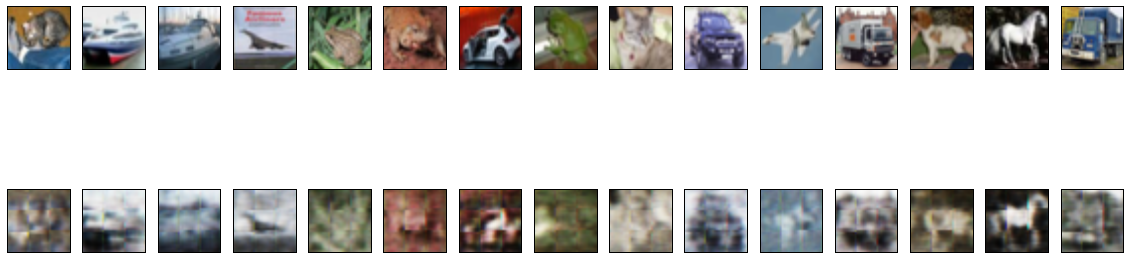

In [81]:
import matplotlib.pyplot as plt

n = 15  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [82]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_46 (Convolution2D) (None, 32, 32, 32)    2432        input_8[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_20 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_46[0][0]           
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_20[0][0]            
___________________________________________________________________________________________

In [83]:
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)

51200000
(50000, 1024)
409600000


In [84]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

10240000
(10000, 1024)
81920000


In [85]:
encoded_train_imgs

array([[ 0.        ,  0.        ,  0.        , ...,  0.26409212,
         0.38924575,  0.40708807],
       [ 0.        ,  0.        ,  0.        , ...,  0.21914735,
         0.16313802,  0.23846534],
       [ 0.        ,  0.        ,  0.        , ...,  0.07881981,
         0.15613696,  0.2161361 ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.16055998,
         0.12803358,  0.23373497],
       [ 0.        ,  0.        ,  0.        , ...,  0.02729381,
         0.11699788,  0.12317668],
       [ 0.        ,  0.        ,  0.        , ...,  0.22746938,
         0.27625847,  0.3827197 ]])

In [86]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(encoded_train_imgs, y_train)

In [87]:
y_pred = clf.predict(encoded_test_imgs)


In [88]:
y_pred

array([0, 8, 8, ..., 5, 6, 4])

In [89]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  3853 wrong:  6147 error rate:  61.47 %
got correctly  38.53 %
